<a href="https://colab.research.google.com/github/seyed-mohammadreza-mousavi/ml-playground-starter/blob/main/random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌲 Random Forests: Theory, Math, and Implementation

This notebook covers:
1) Intuition behind Random Forests
2) Math & impurity measures
3) From-scratch intuition (bagging + random subspaces)
4) Classification example with visual decision boundaries
5) Feature importance, OOB score, and hyperparameter tuning
6) Regression example
7) Practical tips & pitfalls


## 1) Intuition
A **Random Forest** is an ensemble of many **Decision Trees** trained using two sources of randomness:
- **Bootstrap sampling (bagging):** each tree sees a random sample (with replacement) of training rows.
- **Random subspace:** at each split a random subset of features is considered.

Each tree is a high-variance, low-bias model; averaging many *uncorrelated* trees reduces variance without increasing bias too much. For classification the forest predicts by **majority vote**; for regression it predicts the **average** of tree outputs.

## 2) Math
### 2.1 Impurity measures (per node)
- **Gini impurity** (classification):  
$$G = 1 - \sum_{k=1}^{K} p_k^2$$
where $p_k$ is the fraction of class $k$ in the node.
- **Entropy** (classification):  
$$H = -\sum_{k=1}^{K} p_k \log_2 p_k$$
- **Variance / MSE** (regression):  
$$\text{MSE} = \frac{1}{n}\sum_{i=1}^n (y_i - \bar y)^2.$$

A split is chosen to minimize the **impurity after split**:
$$\Delta I = I(\text{parent}) - \sum_{j\in\{L,R\}} \frac{n_j}{n} I(\text{child}_j).$$

### 2.2 Random Forest estimator
Let $T_b(x)$ be the prediction of the $b$-th tree.
- **Regression:**
$$\hat f(x) = \frac{1}{B}\sum_{b=1}^B T_b(x).$$
- **Classification:**
$$\hat y = \text{mode}\big\{T_1(x),\dots,T_B(x)\big\}.$$

### 2.3 Variance reduction (intuition)
If each tree has variance $\sigma^2$ and pairwise correlation $\rho$, the average of $B$ trees has
$$\operatorname{Var}(\bar T) = \rho\sigma^2 + \frac{1-\rho}{B}\sigma^2.$$
Increasing $B$ reduces the second term; lowering correlation $\rho$ (via randomness) reduces the first.

In [1]:
# 3) Setup & helper utilities
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
from matplotlib.colors import ListedColormap

np.random.seed(42)  # reproducibility for numpy operations

def plot_decision_boundary(model, X, y, title="Decision Boundary"):
    X = np.asarray(X)
    y = np.asarray(y)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 400),
        np.linspace(y_min, y_max, 400)
    )
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cmap_light = ListedColormap([[0.85, 0.92, 1.0], [1.0, 0.88, 0.88]])
    cmap_bold = ListedColormap([[0.2, 0.4, 0.8], [0.8, 0.2, 0.2]])
    plt.figure(figsize=(7, 6))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=cmap_light)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=cmap_bold, s=25)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.tight_layout()
    plt.show()

## 4) Classification demo
We'll use a 2D synthetic dataset to visualize the learned decision boundary and explore feature importances, OOB score, and evaluation metrics.

In [2]:
# Generate 2D classification data
X, y = make_classification(
    n_samples=800,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=1.5,
    random_state=42,
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Random Forest with OOB scoring
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    max_features='sqrt',  # classic RF default for classification
    oob_score=True,
    n_jobs=-1,
    random_state=42,
)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.3f}")
print(f"OOB Score:     {clf.oob_score_:.3f}")

Test Accuracy: 0.983
OOB Score:     0.961


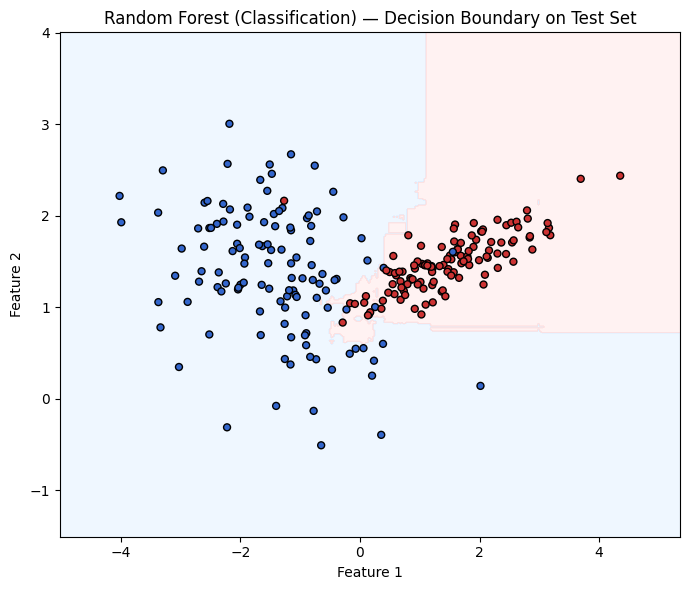

In [3]:
# Visualize decision boundary on test set
plot_decision_boundary(clf, X_test, y_test, title="Random Forest (Classification) — Decision Boundary on Test Set")

In [4]:
# Confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[117   3]
 [  1 119]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       120
           1       0.98      0.99      0.98       120

    accuracy                           0.98       240
   macro avg       0.98      0.98      0.98       240
weighted avg       0.98      0.98      0.98       240



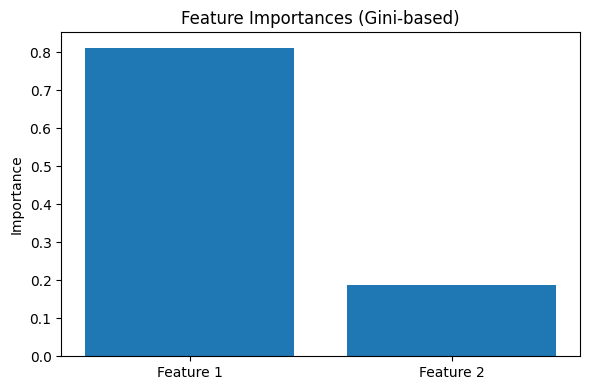

In [5]:
# Feature importance
importances = clf.feature_importances_
feature_names = ["Feature 1", "Feature 2"]
order = np.argsort(importances)[::-1]

plt.figure(figsize=(6, 4))
plt.bar(range(len(importances)), importances[order])
plt.xticks(range(len(importances)), [feature_names[i] for i in order])
plt.ylabel("Importance")
plt.title("Feature Importances (Gini-based)")
plt.tight_layout()
plt.show()

## 5) Hyperparameter tuning (quick grid search)
We'll tune `max_depth`, `min_samples_split`, and `max_features`. In practice consider `RandomizedSearchCV` or specialized libraries for larger searches.

In [6]:
param_grid = {
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "max_features": ["sqrt", 1]
}
grid = GridSearchCV(
    RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
)
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

best_clf = grid.best_estimator_
test_acc = accuracy_score(y_test, best_clf.predict(X_test))
print(f"Test Accuracy (best model): {test_acc:.3f}")

Best params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10}
Best CV score: 0.9553571428571429
Test Accuracy (best model): 0.975


## 6) Regression demo
Now we switch to a regression task to illustrate averaging and partial dependence.

In [8]:
# Synthetic regression data (nonlinear)
Xr, yr = make_regression(
    n_samples=1200,
    n_features=6,
    n_informative=4,
    noise=15.0,
    random_state=42,
)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.25, random_state=42)

regr = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    max_features="sqrt",  # strong default for regression too
    n_jobs=-1,
    random_state=42,
)
regr.fit(Xr_train, yr_train)
yr_pred = regr.predict(Xr_test)

mse = mean_squared_error(yr_test, yr_pred)
rmse = mse ** 0.5
r2 = r2_score(yr_test, yr_pred)
print(f"RMSE: {rmse:.2f}")
print(f"R^2:  {r2:.3f}")

RMSE: 40.52
R^2:  0.920


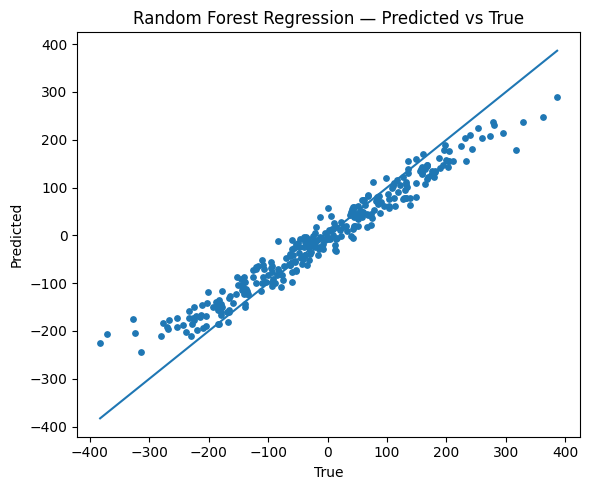

In [9]:
# Plot predicted vs true
plt.figure(figsize=(6, 5))
plt.scatter(yr_test, yr_pred, s=15)
m = min(yr_test.min(), yr_pred.min())
M = max(yr_test.max(), yr_pred.max())
plt.plot([m, M], [m, M])
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Random Forest Regression — Predicted vs True")
plt.tight_layout()
plt.show()

<Figure size 1000x400 with 0 Axes>

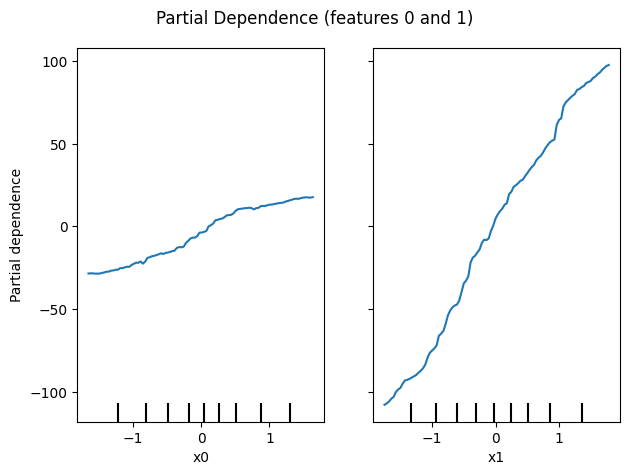

In [10]:
# Partial dependence for the first two features
fig = plt.figure(figsize=(10, 4))
PartialDependenceDisplay.from_estimator(regr, Xr_train, features=[0, 1])
plt.suptitle("Partial Dependence (features 0 and 1)")
plt.tight_layout()
plt.show()

## 7) Practical tips & pitfalls
- **Scale-insensitive:** trees don't require feature scaling.
- **Imbalanced data:** use `class_weight='balanced'` or resampling.
- **OOB estimates:** set `oob_score=True` for fast generalization estimate (classification only in newer sklearn versions; check your version).
- **Feature importance bias:** Gini importance can be biased toward high-cardinality features; consider permutation importance.
- **Calibration:** RF probabilities may be under/overconfident; try `CalibratedClassifierCV` if calibrated probabilities matter.
- **Correlated trees:** reducing `max_features` and increasing data randomness lowers tree correlation and can improve generalization.
- **Compute:** RF parallelizes well via `n_jobs=-1`, but memory use grows with number and depth of trees.
